In [1]:
!pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
import gdown
import os
import pandas as pd
import numpy as np

# The file ID is the part after 'd/' and before '/view' in the URL
file_id = '1ECKyZJrO_w2C1jyC_Zdu04ua_ObgkjPk'
destination = './train.csv'  # Specify the path where you want to save the downloaded file
# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'
# Download the file
gdown.download(download_url, destination, quiet=False)

# The file ID is the part after 'd/' and before '/view' in the URL
file_id = '1BJx7MOHKvPJKgw48oku926DOTAjUY6dF'
destination = './test.csv'  # Specify the path where you want to save the downloaded file
# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'
# Download the file
gdown.download(download_url, destination, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1ECKyZJrO_w2C1jyC_Zdu04ua_ObgkjPk
From (redirected): https://drive.google.com/uc?id=1ECKyZJrO_w2C1jyC_Zdu04ua_ObgkjPk&confirm=t&uuid=e9585acd-74ed-4c8e-927a-71f8844fbe77
To: /content/train.csv
100%|██████████| 238M/238M [00:05<00:00, 46.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BJx7MOHKvPJKgw48oku926DOTAjUY6dF
To: /content/test.csv
100%|██████████| 59.8M/59.8M [00:01<00:00, 40.9MB/s]


'./test.csv'

In [10]:
import pandas as pd
import numpy as np
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Paths to the CSV files
train_path = './train.csv'
test_path = './test.csv'
# lookid_path = './IdLookupTable.csv'

# Read the CSV files
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
# lookid_data = pd.read_csv(lookid_path)

# Columns for Y_train
y_columns = [
    'left_eye_center_x', 'left_eye_center_y',
    'right_eye_center_x', 'right_eye_center_y',
    'nose_tip_x', 'nose_tip_y',
    'mouth_left_corner_x', 'mouth_left_corner_y',
    'mouth_right_corner_x', 'mouth_right_corner_y',
    'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
    'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'
]

# Select the Image column for X_train
X_train = train_data['Image']

# Select the specified columns for Y_train
Y_train = train_data[y_columns]

# Concatenate X_train and Y_train to process all rows
combined_data = pd.concat([X_train, Y_train], axis=1)

# Mediapipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Function to detect face landmarks
def detect_face_landmarks(image):
    results = face_mesh.process(image)
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        return landmarks
    return None

# Process all images using Mediapipe
for idx, row in combined_data.iterrows():
    image = np.fromstring(row['Image'], sep=' ').reshape(96, 96)
    image_rgb = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_GRAY2RGB)

    landmarks = detect_face_landmarks(image_rgb)
    if landmarks:
        # Fill the keypoints using the detected landmarks
        row['nose_tip_x'] = landmarks[4].x * 96
        row['nose_tip_y'] = landmarks[4].y * 96
        row['mouth_left_corner_x'] = landmarks[61].x * 96
        row['mouth_left_corner_y'] = landmarks[61].y * 96
        row['mouth_right_corner_x'] = landmarks[291].x * 96
        row['mouth_right_corner_y'] = landmarks[291].y * 96
        row['mouth_center_top_lip_x'] = landmarks[0].x * 96
        row['mouth_center_top_lip_y'] = landmarks[0].y * 96
        row['mouth_center_bottom_lip_x'] = landmarks[17].x * 96
        row['mouth_center_bottom_lip_y'] = landmarks[17].y * 96
        row['left_eye_center_x'] = landmarks[263].x * 96
        row['left_eye_center_y'] = landmarks[263].y * 96
        row['right_eye_center_x'] = landmarks[33].x * 96
        row['right_eye_center_y'] = landmarks[33].y * 96

        # Update the row in the combined_data DataFrame
        combined_data.loc[idx] = row

# Drop rows still having any missing values (if any)
combined_data = combined_data.dropna()

# Split the combined data back into X_train and Y_train
X_train = combined_data['Image']
Y_train = combined_data[y_columns]

# Convert X_train to numpy array and reshape
X_train = np.array([np.fromstring(image, sep=' ').reshape(96, 96, 1) for image in X_train])
X_train = X_train.astype('float32') / 255.0  # Normalize pixel values

# Convert Y_train to numpy array
Y_train = np.array(Y_train)

print(len(Y_train))


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


6863


In [11]:

# Define a custom Dataset
class FaceKeypointsDataset(Dataset):
    def __init__(self, images, keypoints, transform=None):
        self.images = images
        self.keypoints = keypoints
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        keypoints = self.keypoints[idx]
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define a transformation
class ToTensor(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(), 'keypoints': torch.from_numpy(keypoints).float()}

# # Instantiate the dataset and dataloader
# transform = transforms.Compose([ToTensor()])
# dataset = FaceKeypointsDataset(X_train, Y_train, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Instantiate the dataset and dataloader
transform = transforms.Compose([ToTensor()])
dataset = FaceKeypointsDataset(X_train, Y_train, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Define the model
class KeypointModel(nn.Module):
    def __init__(self):
        super(KeypointModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 30, kernel_size=3)
        self.drop = nn.Dropout(0.3)

        # Calculate the correct input size for the fully connected layer
        self.fc1 = nn.Linear(30 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 14)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.drop(x)
        x = x.view(-1, 30 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Instantiate the model, define the loss function and the optimizer
model = KeypointModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




Using device: cuda


In [12]:
# Train the model
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, sample in enumerate(train_loader):
        images = sample['image'].to(device)
        keypoints = sample['keypoints'].to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(train_loader)}')

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sample in val_loader:
            images = sample['image'].to(device)
            keypoints = sample['keypoints'].to(device)

            outputs = model(images)
            loss = criterion(outputs, keypoints)
            val_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}')


Epoch 1/300, Train Loss: 317.51058662214945
Epoch 1/300, Val Loss: 36.93046419010606
Epoch 2/300, Train Loss: 26.067219700924184
Epoch 2/300, Val Loss: 55.237158753151114
Epoch 3/300, Train Loss: 24.84990759228551
Epoch 3/300, Val Loss: 71.59098789303802
Epoch 4/300, Train Loss: 24.28137917851293
Epoch 4/300, Val Loss: 49.23943665970204
Epoch 5/300, Train Loss: 24.887740368066833
Epoch 5/300, Val Loss: 45.116626118504726
Epoch 6/300, Train Loss: 25.791995148326077
Epoch 6/300, Val Loss: 73.21129909781523
Epoch 7/300, Train Loss: 25.970591827880504
Epoch 7/300, Val Loss: 37.904250078423075
Epoch 8/300, Train Loss: 26.044691274332447
Epoch 8/300, Val Loss: 76.34916917667833
Epoch 9/300, Train Loss: 27.214587832606117
Epoch 9/300, Val Loss: 34.172353079152664
Epoch 10/300, Train Loss: 25.963069827057595
Epoch 10/300, Val Loss: 67.67255445968273
Epoch 11/300, Train Loss: 28.219078285749568
Epoch 11/300, Val Loss: 22.07782394941463
Epoch 12/300, Train Loss: 28.292470571606657
Epoch 12/300, 

In [7]:
# # Train the model
# num_epochs = 300
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, sample in enumerate(dataloader):
#         images = sample['image'].to(device)
#         keypoints = sample['keypoints'].to(device)

#         optimizer.zero_grad()

#         outputs = model(images)
#         loss = criterion(outputs, keypoints)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataloader)}')


Epoch 1/300, Loss: 273.3248768207639
Epoch 2/300, Loss: 24.837382977507836
Epoch 3/300, Loss: 24.919832659876622
Epoch 4/300, Loss: 24.86151611416839
Epoch 5/300, Loss: 25.603433573523233
Epoch 6/300, Loss: 25.601652305070743
Epoch 7/300, Loss: 26.822861121421635
Epoch 8/300, Loss: 26.794686494871627
Epoch 9/300, Loss: 24.606127898637638
Epoch 10/300, Loss: 27.500672202886538
Epoch 11/300, Loss: 25.65313287779342
Epoch 12/300, Loss: 26.38212918569875
Epoch 13/300, Loss: 24.966812714865043
Epoch 14/300, Loss: 23.941136825916377
Epoch 15/300, Loss: 27.688628498343533
Epoch 16/300, Loss: 24.081717748420182
Epoch 17/300, Loss: 25.57656592435615
Epoch 18/300, Loss: 26.416637544853742
Epoch 19/300, Loss: 24.31354180269463
Epoch 20/300, Loss: 24.22355577335801
Epoch 21/300, Loss: 26.22741300449815
Epoch 22/300, Loss: 25.566196845298588
Epoch 23/300, Loss: 24.907043652201807
Epoch 24/300, Loss: 24.308674825623978
Epoch 25/300, Loss: 24.609985631011252
Epoch 26/300, Loss: 24.147423766380133
Epo

KeyboardInterrupt: 

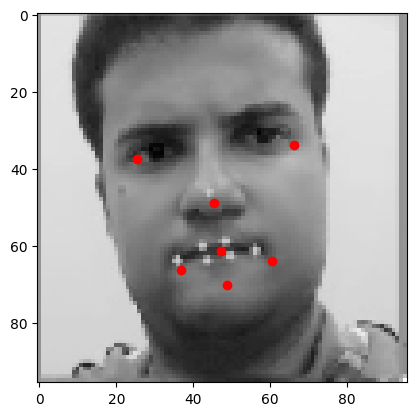

In [17]:

# Define a function to preprocess the image
def preprocess_image(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to 96x96
    image = cv2.resize(image, (96, 96))
    # Normalize the image
    image = image.astype('float32') / 255.0
    # Reshape the image to match the input shape of the model
    image = np.reshape(image, (1, 1, 96, 96))
    return image

# Define a function to plot the image with keypoints
def plot_image_with_keypoints(image_path, keypoints):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to 96x96
    image = cv2.resize(image, (96, 96))

    plt.imshow(image, cmap='gray')
    keypoints = keypoints.reshape(-1, 2)
    for (x, y) in keypoints:
        plt.plot(x, y, 'ro')
    plt.show()

# Preprocess the image
image_path = 'Untitled.png'
preprocessed_image = preprocess_image(image_path)

# Predict the keypoints
model.eval()
with torch.no_grad():
    preprocessed_image_tensor = torch.from_numpy(preprocessed_image).float().to(device)  # Move to the same device as the model
    predicted_points = model(preprocessed_image_tensor)
    predicted_points = predicted_points.cpu().numpy()  # Move back to CPU for plotting

# Plot the image with the predicted keypoints
plot_image_with_keypoints(image_path, predicted_points[0])

In [18]:
# Save the model
torch.save(model.state_dict(), 'keypoints_model.pth')


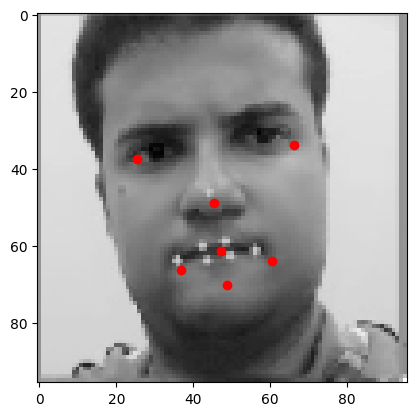

In [19]:

# Load the saved model
model = KeypointModel()
model.load_state_dict(torch.load('keypoints_model.pth', map_location=torch.device('cpu')))
model.eval()


# Preprocess the image
image_path = 'Untitled.png'
preprocessed_image = preprocess_image(image_path)

# Convert the preprocessed image to PyTorch Tensor
input_tensor = torch.from_numpy(preprocessed_image).float()

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor)
    predicted_points = outputs.numpy()

# Plot the image with the predicted keypoints
plot_image_with_keypoints(image_path, predicted_points[0])
